The purpose of this Assignment is to derive reasonable no-arbitrage prices of a couple of simple derivatives written on an asset that presents "non-standard" dynamics.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize


# 1. Problem
*PROBLEM QUESTION:
Looking at both the realized series at your disposal and at the SDE in (1), which kind of market variable (an equity price, a commodity price, an interest rate, ...) can be reasonably represented by X? Justify your answer.*

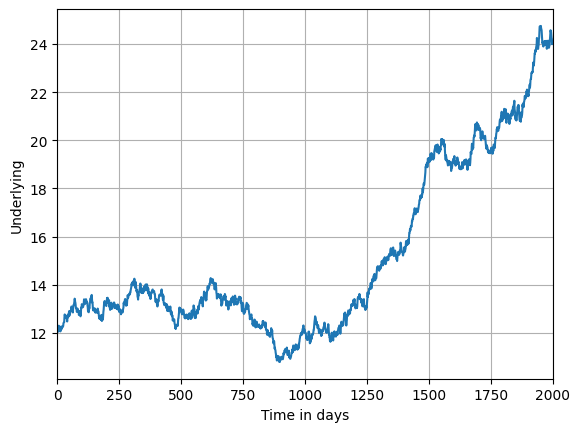

In [5]:
df = pd.read_excel('Price_Time_Series.xlsx')
prices = np.array(df['X(t)'])
plt.plot(range(0,len(prices)), prices)
plt.xlabel('Time in days')
plt.ylabel('Underlying')
plt.xlim(0, len(prices))
plt.grid(True)

We can distinguish three distinct dynamics. From day 0 to day 750 (roughly), we observe a volatile and low growth trend. This is followed by a decay-like dynamic that lasts until day 800, and a subsequent sharp growth trend. The dynamics and values assumed by the underlying appear to be more supportive of the emerging markets interest rate hypothesis.

# 2. Problem

*PROBLEM QUESTION: Conditioning on the first realized value and on an educated guess for the parameters, use a Euler discretization of the SDE to recursively compute the time series of the standard
normally distributed shocks.*

Rearranging the stochastic differential equation  $dX_t = \kappa X_t dt + \sigma \sqrt{X_t} \, dW_t^\mathbb{Q}$, we obatin
$Z = \frac{1}{\sqrt{dt}}\frac{dX_t - \kappa X_t dt}{\sigma \sqrt{X_t}} \sim N(0, 1)$


In [6]:
N = len(prices) - 1
dt = 1/250

def estimate_shocks(prices, kappa, sigma, dt):
    shocks = []
    for i in range(N):
        Xt_0 = prices[i]
        Xt_1 = prices[i+1]
        Zt = (Xt_1 - Xt_0 - kappa * Xt_0 * dt) / (sigma * np.sqrt(Xt_0)*np.sqrt(dt))
        shocks.append(Zt)
    return np.array(shocks)

In [7]:
# Initial guesses
kappa_guess = 0.2
sigma_guess = 0.4

In [8]:
# Shocks estimation
shocks = estimate_shocks(prices, kappa_guess, sigma_guess,dt)
mean = np.mean(shocks)
std = np.std(shocks)
distribution_parameters = [mean, std]
print(f'The shocks are distributed with mean {mean:.3f} and variance {std**2:.3f}')

The shocks are distributed with mean -0.065 and variance 0.988


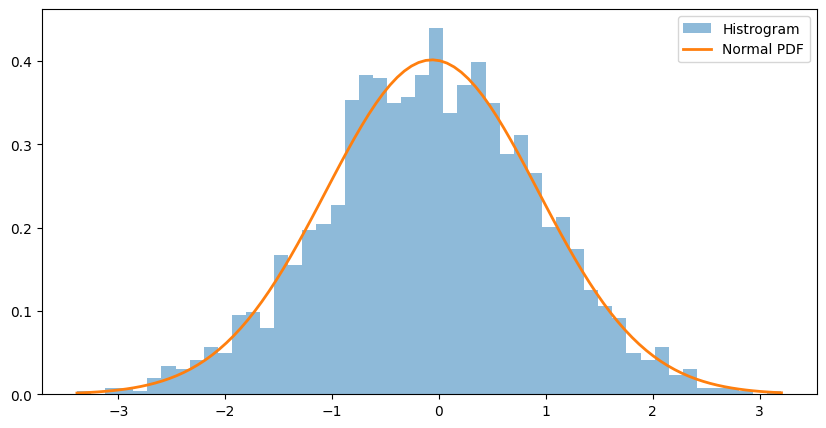

In [9]:
# Shock's distribution shocks
deltas = np.linspace(min(shocks), max(shocks), 100)
PDF_norm = stats.norm.pdf(deltas, mean, std)
plt.figure(figsize=(10, 5))
plt.hist(shocks, density = True, label='Histrogram', alpha = 0.5, bins = 50)
plt.plot(deltas, PDF_norm, linewidth = 2, label = 'Normal PDF')
plt.legend();

((array([-3.39232293, -3.14126578, -3.00201262, ...,  3.00201262,
          3.14126578,  3.39232293]),
  array([-3.38642504, -3.08981242, -2.99748563, ...,  2.7914727 ,
          2.87586595,  3.20385656])),
 (np.float64(0.9951215132907868),
  np.float64(-0.06463651319485644),
  np.float64(0.9996863064428096)))

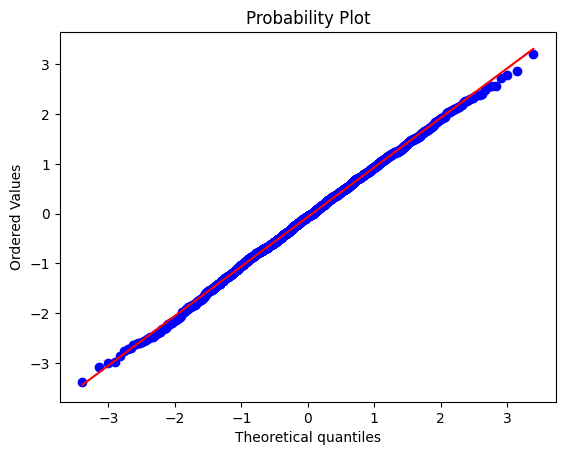

In [10]:
# QQ-plot shocks
stats.probplot(shocks, dist="norm", plot=plt)

In [11]:
# Jarque-Brera test
JB_test = stats.jarque_bera(shocks)
print(f'Given the p-value of {JB_test[1]}, we can fail to reject the null hypothesis at a confidence level of 0.05 under which we are normally distributed.' if JB_test[1] > 0.05
       else 'Given the value of the p-value, we reject the null hypothesis at a confidence level of 0.05.')

Given the p-value of 0.3552357568039025, we can fail to reject the null hypothesis at a confidence level of 0.05 under which we are normally distributed.


# 3. Problem
*PROBLEM QUESTION: Relying on the normality assumption of the shocks from point (2) recursively derive the expected value and the variance of  $X_t$ as a function of $X_{t+\Delta t}$ and $\Theta$.*

In order to obtain the MLE-based estimate of $\Theta$ we discretize the underlying stochastic process $X_t$:

$ X_{t+\Delta t} = X_t + \kappa X_t \Delta t + \sigma \sqrt{X_t} \, \sqrt{\Delta t} \, N(0,1)  $

From the Euler discretization of the process $X_t$ we infer that the unconditional expected value and variance can be derived as:

${E}[X_{t+\Delta t}] = X_t + \kappa X_t \Delta t \\ $

$Var(X_{t+\Delta t}) = \sigma^2 \, X_t \Delta t \\ $

In [12]:
def likelihood_forX(x, data):
  kappa = x[0]
  sigma = x[1]

  drift = np.zeros(len(data)-1)
  diffusion = np.zeros(len(data)-1)

  for i in range(len(data)-1):
    drift[i]= data[i] + data[i] * kappa * dt
    diffusion[i]= sigma * np.sqrt(data[i]) * np.sqrt(dt)

  return -np.sum( np.log( stats.norm.pdf(data[1:], loc = drift, scale = diffusion) ) )

initialGuess = [kappa_guess, sigma_guess]
bounds = [(0, None), (0, None)] # Both kappa and sigma must be positive

MLEoutput_forX = minimize(likelihood_forX, initialGuess, args = prices, bounds = bounds, method = 'Nelder-Mead')

kappa_MLE, sigma_MLE = MLEoutput_forX.x
print(f'The optimal parameters are: 1. kappa = {kappa_MLE:.4f} 2. sigma = {sigma_MLE:.4f}')

The optimal parameters are: 1. kappa = 0.0981 2. sigma = 0.3976


# 4. problem
*PROBLEM QUESTION: Using MC tehniques estimate the price at $t=0$ of the plain vanilla European call on the underlying.*

Starting from the Euler discretization of the process, we simulate the evolution of the underlying updating its price  at each time interval derived subdividing the period $T$ into small time intervals ${\Delta t}$ of length $T/n$. Setting $\Delta t = \frac{1}{250}$, taking a unit measurement of time of one year and accounting for daily observations, we obtain the number of steps $n = \frac{T}{\Delta t} = 150.$ \\

We repeat this simulation $nsim = 10000$ times in order to obtain simulations of the path of the stochastic process of the underlying $X_t$. For each simulation, we calculate the final value $X_T$ and the option payoff. Finally, we estimate the option price at $t=0$ by taking the average all the simulated payoffs and discounting it.

In [13]:
# European Call option parameters
K = prices[-1]
T = 0.6
r  = 0.02

kappa = kappa_MLE
sigma = sigma_MLE

In [14]:
# Simulation parameters
n = 150
dt = T/n       # obtain daily observations
nsim = 20000

In [15]:
# Monte Carlo simulations
X_t0 = prices[-1]
X_hat = np.zeros( shape = (nsim, n+1) )
X_hat[ : , 0] = X_t0

for i in range( int(n) ):
  X_hat[:, i+1] = X_hat[:, i] + kappa*X_hat[:, i]*dt + sigma*np.sqrt(X_hat[:, i])*np.sqrt(dt)*np.random.normal(0, 1, nsim)

In [16]:
# Retrieving the price of the European call option discounting the expected payoff
payoffs = np.maximum(X_hat[:,-1] - K, 0)
call_MC = np.exp(-r * T) * np.mean(payoffs)
print(f'The price of the european call with Monte Carlo method is: {call_MC:.4f}')

The price of the european call with Monte Carlo method is: 1.5746


(0.0, 0.6)

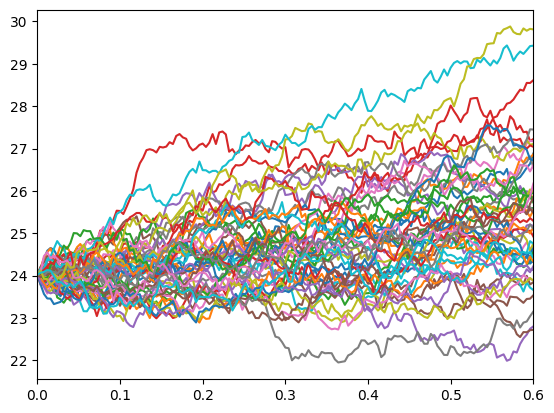

In [17]:
# Monte Carlo simulations
ts = np.linspace( 0, 0.6, n+1 )

for i in range(50):
  plt.plot(ts, X_hat[i,:])
plt.xlim(0, 0.6)

In addition, we show the convergence of the derivative price using Monte Carlo simulation as the number of simulations increases below

In [18]:
# Define a function for the Monte Carlo simulation suited to our stochastic process
def CallOptionMC(S0, K, r, sigma, kappa, T, nsim):
  n = 150
  dt = T/n

  X_hat = np.zeros(shape=(nsim, n+1))
  X_hat[:,0] = X_t0

  for i in range(1,n+1):
    X_hat[:,i] = X_hat[:,i-1] + kappa*X_hat[:,i-1] * dt + sigma * np.sqrt(X_hat[:,i-1]) * np.sqrt(dt) * np.random.normal(0, 1, nsim)
  discPayoff = np.maximum(X_hat[:,-1] - K, 0)
  output = np.zeros(shape=2)
  output[0] = discPayoff.mean()
  output[1] = discPayoff.std()*1.96/np.sqrt(nsim)
  return output

In [19]:
NSim = np.array([50, 100, 500, 1000, 5000, 10000, 20000])
MCprices = np.zeros(NSim.shape)
MCradius = np.zeros(NSim.shape)

i = 0

for j in NSim:
  tempOutcall = CallOptionMC(prices[-1], K, r, sigma, kappa, T, j)
  MCprices[i] = tempOutcall[0]
  MCradius[i] = tempOutcall[1]
  i += 1

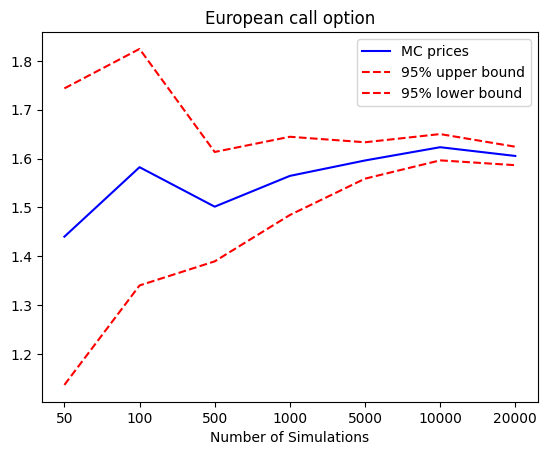

In [20]:
uB_CI = MCprices + MCradius
lB_CI = MCprices - MCradius

plt.plot(MCprices,'b',label = "MC prices")
plt.plot(uB_CI,'r--', label = "95% upper bound")
plt.plot(lB_CI,'r--', label = "95% lower bound")
plt.xlabel('Number of Simulations')
plt.xticks(np.arange(0, NSim.shape[0]), NSim)
plt.title("European call option")
plt.legend();

# 5. problem
*PROBLEM QUESTION: Compute the price at $t=0$ of the plain vanilla European call on the underlying by backward recursion along a computationally feasible lattice discretization of $X_t$.*

Firstly, we define needed functions, namely:
1.   function $f$ - allows us to obtain transformation $f(X_t)$ with constant diffusive coefficient; used to create the lattice of $f(X_t)$
2.   the inverse of $f$ - used to map the former lattice to $X_t$
3. function $q$ - assigns each node in the lattice the probaility of upward movement

Secondly, we initialise and build the lattice discretization of $f(X_t)$, building lattice $X_t$ in parallel which stores the inverse elements of $f(X_t)$.

Finally, using backward recursion we estimate the option price at $t=0$.

We fix the parameter $dt = \frac{1}{250}$, therefore $n = 150$, as in Problem 4 for consistency. We will do so as well in the following problems.

In [21]:
# Simulation parameters
n = 150
dt = T/n      # obtain daily observations

In [22]:
# Define increment of f(X_t) and functions
df = np.sqrt(dt)

def f(x):
  return 2 / sigma * np.sqrt(x)

def f_inv(y):
  return (y * sigma / 2)**2

def q(x):
  return 0.5*(1 + df*(kappa*np.sqrt(x)/sigma - sigma/(4*np.sqrt(x))))

In [23]:
# Building the computationally feasible lattice discretization
fX_tree = np.zeros(shape=(n+1,n+1))
X_tree = np.zeros(shape=(n+1,n+1))
X_tree[0,0] = X_t0
fX_tree[0,0] = f(X_t0)

for i in range(1,int(n+1)):
  for j in range(int(i+1)):
    if(i == j):
      fX_tree[j,i] = fX_tree[j-1, i-1] - df
    else:
      fX_tree[j,i] = fX_tree[j, i-1] + df
    X_tree [j,i] = f_inv(fX_tree[j,i])

In [24]:
# Backward recursion
E_payoff = np.zeros(shape=(n+1,n+1))
E_payoff[:,-1] = np.maximum(X_tree[:,-1] - K, 0)

for i in range(int(n)):
  for j in range(int(n-i)):
    prob = np.maximum(0, np.minimum(1, q(X_tree[j,n-i-1])))
    E_payoff[j,n-i-1] = np.exp(-r*dt)*(prob*E_payoff[j,n-i]+(1-prob)*E_payoff[j+1,n-i])

call_lattice = E_payoff[0,0]
print(f'The price of the european call using backward recursion along a computationally feasible lattice discretization is: {call_lattice:.4f}')

The price of the european call using backward recursion along a computationally feasible lattice discretization is: 1.5816


# 6. problem
*PROBLEM QUESTION: Compute the price at $t = 0$ of the plain vanilla European call on the underlying by solving the PDE-representation of the (discounted) expected value in (2) by means of a finite difference explicit scheme.*

As a first step, we discretize the time and space grid by dividing the time horizon into steps ${\Delta t}$ and the underlying domain into steps
${\Delta x}$, allowing us to approximate the partial derivatives with respect to $t$ and twice with respect to $x$ using finite differences. Then, at the edges of the grid, boundary conditions are set to ensure that the numerical solution of the PDE is well-defined and that the method produces results consistent with the expected behavior of the derivative. To obtain the value of the derivative, we start from the final condition, i.e., the option’s payoff at time $T$, and iterate backward in time to update the value of the derivative node by node.

\begin{equation*}\
    f_{i,j} = \Delta t \left[ \frac{f_{i+1,j-1}}{2} \left( \sigma^2 \frac{j}{\Delta x} - \kappa j \right)  
    + f_{i+1,j} \left(\frac{1}{\Delta t} - r - \sigma^2 \frac{j}{\Delta x} \right)  
    + \frac{f_{i+1,j+1}}{2} \left( \sigma^2 \frac{j}{\Delta x} + \kappa j \right) \right]
    \end{equation*}








In [25]:
# Set up the grid for t and X
Xmax = 2*X_t0

mt = 150    # = n
mx = 100

dt = T/mt   # = dt as before
dx = Xmax/mx

nodest = np.linspace(0,T,mt+1)
nodesX = np.linspace(0,Xmax,mx+1)

z = (T/Xmax**2) * mx**2/mt
print(z)

0.017329339204467054


In [26]:
# Setting the grid and the boundary conditions
grid = np.zeros(shape=(mt+1,mx+1))

grid[-1,:] = np.maximum(nodesX - K, 0)
grid[:,-1] = np.flip(np.exp(-r * nodest)) * (Xmax - K)
grid[:,0] = 0

In [27]:
# Filling the grid
for i in range(1,mt+1):
  for j in range(1,mx):
    grid[mt-i,j] = dt*(grid[mt-i+1,j-1]/2*(sigma**2*j/dx-kappa*j) +\
                    grid[mt-i+1,j]*(1/dt -r -sigma**2*j/dx) +\
                    grid[mt-i+1,j+1]/2*(sigma**2*j/dx+kappa*j))

In [28]:
# Casting the 2-dimensional np.array into a dataframe for a convenient visualization
visual_test = pd.DataFrame(grid)

In [29]:
# Retrieving the premium of the option
grid[0,int(mx/2)]
print(f'The price of the european call with lattice methodology is: {grid[0,int(mx/2)]:.4f}')

The price of the european call with lattice methodology is: 1.5733


#7. problem

*PROBLEM QUESTION: Using a numerical technique of your choice, compute the price at inception $\pi_0^A$ of the American version of the call option previously analysed. Namely, compute*

$$\begin{equation}
\pi_0^A = \sup_{\tau \in [0,T]} \mathbb{E}^{\mathbb{Q}} \left[ e^{-r(T-\tau)} (X_{\tau} - K)^+ \right]
\end{equation}$$

*and the early exercise premium $\pi_0^A - \pi_0^E$, if any.*

The price of the American version of the call option previously analysed has been computed using backward recursion along the lattice discretization of $X$ found out in point $5$.
At each time step, we compare:
        
- The continuation value, representing the expected discounted value of holding the option.
- The immediate exercise value, given by the intrinsic value of the option.
        
Using backward recursion we estimate the option price at $t=0$.
From the results, we observe that the American call option has the same price as the European call option. This implies that early exercise is never optimal, and therefore, there is no early exercise premium at $t=0$.

In [30]:
# Simulation parameters
n = 150
dt = T/n      # obtain daily observations

In [31]:
AmCallPrices = np.zeros(shape=(n+1,n+1))
AmCallPrices[:,-1] = np.maximum(X_tree[:,-1] - K, 0)
discFct = np.exp(-r*dt)

for i in range(int(n)):
  for j in range(int(n-i)):
    prob = np.maximum(0, np.minimum(1, q(X_tree[j,n-i-1])))
    # immediate exercise value
    IV = np.maximum(0, X_tree[j, n-i-1]-K)
    # continuation value
    CV = discFct*(prob*AmCallPrices[j, n-i] + (1-prob)*AmCallPrices[j+1, n-i])
    AmCallPrices[j, n-i-1] = np.maximum(CV, IV)

print(f'The price of the american call using backward recursion along a computationally feasible lattice discretization is: {AmCallPrices[0,0]:.4f}')
Early_ex_premium = AmCallPrices[0,0] - call_lattice
print(f'The early exercise premium is: {Early_ex_premium:.4f}')

The price of the american call using backward recursion along a computationally feasible lattice discretization is: 1.5816
The early exercise premium is: 0.0000


# 8. problem
*PROBLEM QUESTION: Given $B > X(0)$, compute the payoff at maturity $T$ of the up-and-out barrier version of the (European) call option previously analysed is
\begin{cases}
(X_T - K)^{+} & \text{if } \max_{t \in [0,T]} S(t) \leq B \\
0 & \text{else}
\end{cases}*

Starting from a new Monte Carlo simulation, the pay-off at maturity is calculated as a European plain vanilla call option. To capture the path-dependence nature of the barrier option, a
restriction is applied to the pay-off vector: any in-the-money option is excluded if the price trajectory of the underlying has exceeded the predetermined barrier level, $B$, during the lifetime of the
derivative.

In addition, exploiting the property of barrier options that the price of an up-knock-in call and the price of an up-knock-out summed must return the price of a plain vanilla call option with the same contractual characteristics, the corresponding up-knock-in 'twin' was also priced to verify the correct pricing of the exotic derivative.

In [32]:
# Simulation parameters
n = 150
dt = T/n      # obtain daily observations
nsim = 10000

In [33]:
# Barrier up-and-out with Monte Carlo
B = 28

X_hat = np.zeros(shape=(nsim, n+1))
X_hat[:,0] = X_t0

for i in range(1,n+1):
  X_hat[:,i] = X_hat[:,i-1] + kappa * X_hat[:,i-1]*dt + sigma * np.sqrt(X_hat[:,i-1]) * np.sqrt(dt) * np.random.normal(0, 1, nsim)

crossing = np.any(X_hat[:, 1:] >= B, axis=1)
not_crossing = ~crossing

call_knock_out_payoff = np.maximum(X_hat[:, -1] - K, 0) * not_crossing
call_knock_in_payoff = np.maximum(X_hat[:, -1] - K, 0) * crossing

call_knock_out = np.mean(call_knock_out_payoff) * np.exp(-r * T)
call_knock_in = np.mean(call_knock_in_payoff) * np.exp(-r * T)

vanilla_call = call_knock_in + call_knock_out

print(f'The price of the Barrier up-and-out with Monte carlo is: {call_knock_out:.4f}')
print(f'The price of the Barrier up-and-in with Monte carlo is: {call_knock_in:.4f}')
print(f'The price of the vanilla call with Monte carlo is: {vanilla_call:.4f}')

The price of the Barrier up-and-out with Monte carlo is: 1.2311
The price of the Barrier up-and-in with Monte carlo is: 0.3380
The price of the vanilla call with Monte carlo is: 1.5690
